In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from pingouin import bayesfactor_ttest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

## Women with ADHD vs. Men with ADHD

In [2]:
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-liwc-proportional.pkl")
mask_women = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = (df['sex']=="Masculino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
features = df.columns[-64:].tolist()

In [3]:
# Check the size of women with ADHD group
mask_women_len = mask_women.sum()
print(f"Women with ADHD: {mask_women_len}")
print(f"Men with ADHD: {mask_others.sum()}")

# Check if any LIWC features have constant values (zero variance)
for feat in features[:5]:  # Check first 5 features as example
    g1 = df.loc[mask_women, feat].dropna()
    g2 = df.loc[mask_others, feat].dropna()
    print(f"\n{feat}:")
    print(f"  Women - min: {g1.min():.4f}, max: {g1.max():.4f}, std: {g1.std():.4f}")
    print(f"  Men - min: {g2.min():.4f}, max: {g2.max():.4f}, std: {g2.std():.4f}")

Women with ADHD: 23
Men with ADHD: 10

funct:
  Women - min: 0.0000, max: 0.5029, std: 0.1222
  Men - min: 0.3279, max: 0.5017, std: 0.0498

pronoun:
  Women - min: 0.0000, max: 0.2356, std: 0.0632
  Men - min: 0.0984, max: 0.3125, std: 0.0587

ppron:
  Women - min: 0.0000, max: 0.1538, std: 0.0489
  Men - min: 0.0656, max: 0.2500, std: 0.0540

i:
  Women - min: 0.0000, max: 0.1250, std: 0.0323
  Men - min: 0.0000, max: 0.1250, std: 0.0345

we:
  Women - min: 0.0000, max: 0.0000, std: 0.0000
  Men - min: 0.0000, max: 0.0000, std: 0.0000


In [4]:
df = df.drop(columns=['we'], errors='ignore')
features.remove('we')

## Necessary functions

In [5]:
def univariate_liwc(df, features, mask_g1, mask_g2, alpha=0.05):
    """
    For each LIWC feature:
      - Welch’s t-test
      - JZS Bayes factor
      - Cohen’s d
    Returns a DataFrame with p-values, BF10, d, FDR‐corrected p’s, etc.
    """
    rows = []
    for feat in features:
        g1 = df.loc[mask_g1, feat].dropna()
        g2 = df.loc[mask_g2, feat].dropna()
        t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
        n1, n2 = len(g1), len(g2)
        bf10 = bayesfactor_ttest(t_stat, n1, n2, paired=False)
        s1, s2 = g1.std(ddof=1), g2.std(ddof=1)
        s_pool = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
        d = (g1.mean() - g2.mean())/s_pool
        rows.append({
            'feature': feat,
            'mean_g1': g1.mean(),
            'sd_g1': s1,
            'mean_g2': g2.mean(),
            'sd_g2': s2,
            't_stat': t_stat,
            'p_val': p_val,
            'bf10': bf10,
            'cohen_d': d
        })
    df_res = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_res['p_val'], method='fdr_bh')
    df_res['p_fdr'] = p_corr
    df_res['signif'] = df_res['p_fdr'] <= alpha
    df_res['abs_cohen_d'] = df_res['cohen_d'].abs()
    return df_res.sort_values('abs_cohen_d', ascending=False)

In [6]:
def pca_group_diff(df, features, mask_g1, mask_g2, n_pc=5, alpha=0.05):
    """
    Standardize LIWC features, run PCA, perform Welch’s t-test on each PC
    Returns a DataFrame of PC, explained_variance, t_stat, p_val, p_fdr.
    """
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_pc)
    pcs = pca.fit_transform(Xs)
    rows = []
    for i in range(n_pc):
        comp = pcs[:, i]
        t, p = stats.ttest_ind(comp[mask_g1], comp[mask_g2], equal_var=False)
        rows.append({
            'PC': f'PC{i+1}',
            'expl_var': pca.explained_variance_ratio_[i],
            't_stat':   t,
            'p_val':    p
        })
    df_pc = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_pc['p_val'], method='fdr_bh')
    df_pc['p_fdr'] = p_corr
    return df_pc

In [7]:
def top_pc1_loadings(df, features, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=1)
    pca.fit(Xs)
    load = pd.Series(pca.components_[0], index=features)
    df_load = load.abs().sort_values(ascending=False).head(n).to_frame('abs_loading')
    df_load['loading'] = load.loc[df_load.index]
    return df_load

In [8]:
def l1_logistic_top(df, features, mask_g1, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    y = mask_g1.astype(int)
    clf = LogisticRegressionCV(
        Cs=10, cv=5, penalty='l1', solver='saga',
        scoring='roc_auc', max_iter=5000, random_state=42
    )
    clf.fit(Xs, y)
    coef = pd.Series(clf.coef_[0], index=features)
    df_coef = coef.abs().sort_values(ascending=False).head(n).to_frame('abs_coef')
    df_coef['coef'] = coef.loc[df_coef.index]
    return df_coef

In [9]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / s_pooled

In [10]:
def abs_cohen_d(x, y):
    return abs(cohen_d(x, y))

In [11]:
def bootstrap_ci(x, y, statfunc, n_boot=1000, ci=95):
    boot_stats = []
    for _ in range(n_boot):
        bx = resample(x, replace=True)
        by = resample(y, replace=True)
        boot_stats.append(statfunc(bx, by))
    lower = np.percentile(boot_stats, (100-ci)/2)
    upper = np.percentile(boot_stats, 100-(100-ci)/2)
    return lower, upper

In [12]:
def a_priori_power(effect_size=0.6, alpha=0.05, power=0.8):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

## Analysis

In [13]:
# 1) Univariate LIWC
uni = univariate_liwc(df, features, mask_women, mask_others)
print("\nLIWC dimensions |d| > 0.5:")
print(uni[uni['abs_cohen_d']>0.5].to_markdown(index=False, floatfmt=".3f"))


LIWC dimensions |d| > 0.5:
| feature   |   mean_g1 |   sd_g1 |   mean_g2 |   sd_g2 |   t_stat |   p_val |   bf10 |   cohen_d |   p_fdr | signif   |   abs_cohen_d |
|:----------|----------:|--------:|----------:|--------:|---------:|--------:|-------:|----------:|--------:|:---------|--------------:|
| money     |     0.018 |   0.013 |     0.033 |   0.015 |   -2.660 |   0.017 |  4.328 |    -1.045 |   0.811 | False    |         1.045 |
| assent    |     0.001 |   0.002 |     0.006 |   0.011 |   -1.335 |   0.213 |  0.683 |    -0.753 |   0.811 | False    |         0.753 |
| ipron     |     0.088 |   0.046 |     0.119 |   0.036 |   -2.078 |   0.050 |  1.687 |    -0.717 |   0.811 | False    |         0.717 |
| excl      |     0.033 |   0.024 |     0.046 |   0.014 |   -1.930 |   0.064 |  1.371 |    -0.604 |   0.811 | False    |         0.604 |
| pronoun   |     0.135 |   0.063 |     0.171 |   0.059 |   -1.581 |   0.131 |  0.886 |    -0.582 |   0.811 | False    |         0.582 |
| adverb    |

In [14]:
# 2) Bootstrap CIs for features with |d| > 0.5
top_feats = uni[uni['abs_cohen_d'] > 0.5]['feature']
ci_list = []
for feat in top_feats:
    x = df.loc[mask_women, feat].dropna().values
    y = df.loc[mask_others, feat].dropna().values
    d_obs = cohen_d(x, y)
    lo, hi = bootstrap_ci(x, y, cohen_d, n_boot=2000, ci=95)
    ci_list.append({'feature': feat, 'd': d_obs, 'ci_lower': lo, 'ci_upper': hi})
ci_df = pd.DataFrame(ci_list)
print("\nBootstrap 95% CIs for Cohen's d (|d| > 0.5):")
print(ci_df.to_markdown(index=False, floatfmt=".3f"))


Bootstrap 95% CIs for Cohen's d (|d| > 0.5):
| feature   |      d |   ci_lower |   ci_upper |
|:----------|-------:|-----------:|-----------:|
| money     | -1.045 |     -1.837 |     -0.371 |
| assent    | -0.753 |     -1.503 |      0.275 |
| ipron     | -0.717 |     -1.323 |     -0.105 |
| excl      | -0.604 |     -1.324 |     -0.018 |
| pronoun   | -0.582 |     -1.220 |      0.055 |
| adverb    | -0.538 |     -1.306 |      0.248 |
| space     | -0.533 |     -1.095 |     -0.007 |
| shehe     | -0.528 |     -1.291 |      0.115 |
| you       | -0.526 |     -1.361 |      0.199 |


In [15]:
# 3) A priori power
req_n = a_priori_power(effect_size=0.6)
print(f"\nRequired N per group for d=0.6, α=0.05, 80% power: {req_n:.1f}")


Required N per group for d=0.6, α=0.05, 80% power: 44.6


In [16]:
# 4) PCA group differences
pc_res = pca_group_diff(df, features, mask_women, mask_others)
print("\nPCA group differences:")
print(pc_res.to_markdown(index=False, floatfmt=".3f"))


PCA group differences:
| PC   |   expl_var |   t_stat |   p_val |   p_fdr |
|:-----|-----------:|---------:|--------:|--------:|
| PC1  |      0.151 |   -1.944 |   0.061 |   0.306 |
| PC2  |      0.082 |   -0.103 |   0.919 |   0.919 |
| PC3  |      0.070 |   -0.149 |   0.883 |   0.919 |
| PC4  |      0.063 |    0.168 |   0.867 |   0.919 |
| PC5  |      0.054 |    0.206 |   0.838 |   0.919 |


In [17]:
# 5) PCA group differences
pc1_ld = top_pc1_loadings(df, features, n=15)
print("\nTop PC1 loadings:")
print(pc1_ld[['loading']].to_markdown(floatfmt=".3f"))


Top PC1 loadings:
|         |   loading |
|:--------|----------:|
| ipron   |     0.275 |
| funct   |     0.274 |
| pronoun |     0.274 |
| nonfl   |     0.241 |
| shehe   |     0.238 |
| article |     0.237 |
| social  |     0.230 |
| you     |     0.224 |
| ppron   |     0.220 |
| cogmech |     0.220 |
| space   |     0.206 |
| preps   |     0.173 |
| incl    |     0.168 |
| discrep |     0.162 |
| excl    |     0.162 |


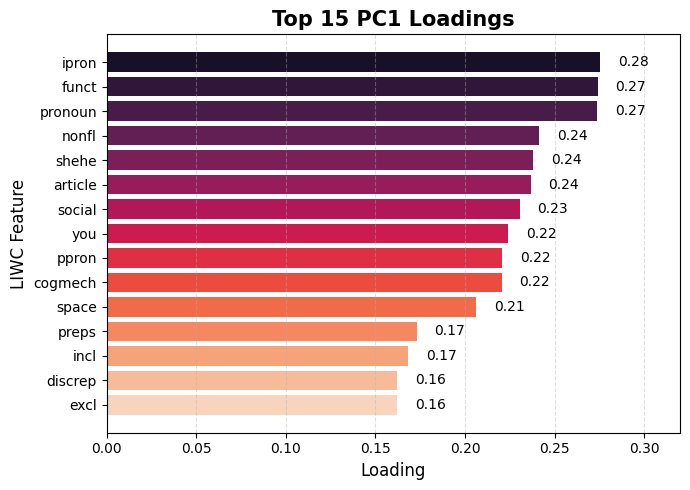

In [18]:
# Use seaborn's rocket palette for colors
palette = sns.color_palette("rocket", len(pc1_ld))

plt.figure(figsize=(7, 5))
bars = plt.barh(pc1_ld.index, pc1_ld['loading'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 PC1 Loadings", fontsize=15, weight='bold')
plt.xlabel("Loading", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with loading values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.01 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(0, 0.32)

plt.tight_layout()
plt.show()

In [19]:
# 6) L1 logistic features
lasso = l1_logistic_top(df, features, mask_women, n=15)
print("\nTop L1 logistic features:")
print(lasso[['coef']].to_markdown(floatfmt=".3f"))


Top L1 logistic features:
|         |   coef |
|:--------|-------:|
| conj    |  2.779 |
| cogmech | -2.487 |
| number  |  1.482 |
| money   | -1.436 |
| certain |  1.371 |
| feel    |  1.340 |
| achieve | -1.330 |
| relig   | -1.192 |
| negemo  |  1.104 |
| excl    | -1.072 |
| assent  | -1.048 |
| verb    |  0.976 |
| motion  | -0.972 |
| negate  |  0.925 |
| auxverb |  0.868 |


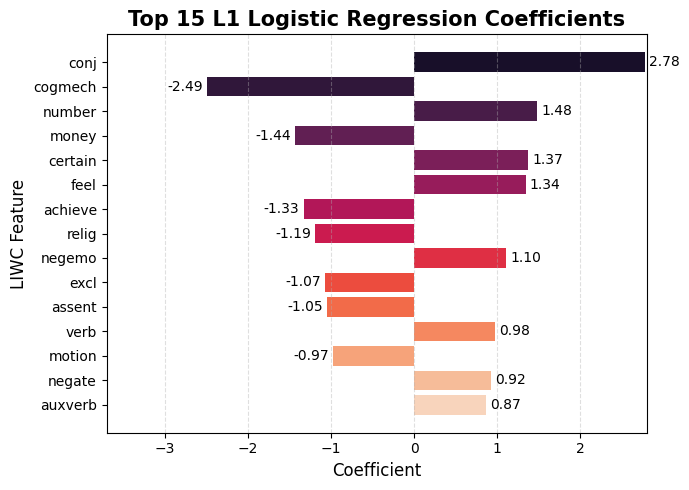

In [20]:
# Plotting top L1 logistic coefficients with seaborn's rocket palette
plt.figure(figsize=(7, 5))
palette = sns.color_palette("rocket", len(lasso))
bars = plt.barh(lasso.index, lasso['coef'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 L1 Logistic Regression Coefficients", fontsize=15, weight='bold')
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with coefficient values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.05 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(-3.7, 2.8)

plt.tight_layout()
plt.show()

In [21]:
# 7) Repeated CV for AUC stability
X = df[features].fillna(0).values
y = mask_women.astype(int).values
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
auc_scores = cross_val_score(clf, X, y, cv=rkf, scoring='roc_auc')
print(f"\nRepeated CV AUC: mean={auc_scores.mean():.3f}, SD={auc_scores.std():.3f}")


Repeated CV AUC: mean=0.541, SD=0.079


In [22]:
# 8) Stability selection via bootstrap Lasso
n_boot = 100
feat_counts = pd.Series(0, index=features)
for _ in range(n_boot):
    idx = np.random.choice(len(df), len(df), replace=True)
    Xb = X[idx]
    yb = y[idx]
    clf = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000)
    clf.fit(StandardScaler().fit_transform(Xb), yb)
    feat_counts += (np.abs(clf.coef_[0]) > 1e-6).astype(int)
stability = (feat_counts / n_boot).sort_values(ascending=False)
print("\nFeatures selected in ≥85% of bootstraps:")
print(stability[stability>=0.85].to_markdown(floatfmt=".2f"))


Features selected in ≥85% of bootstraps:
|         |    0 |
|:--------|-----:|
| number  | 0.94 |
| conj    | 0.91 |
| negate  | 0.88 |
| achieve | 0.88 |
| assent  | 0.87 |
| cogmech | 0.86 |
